### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


In [4]:
States_track = collections.defaultdict(dict)
Q_dict = collections.defaultdict(dict)

In [5]:
def Q_state(state):
    return '-'.join(str(e) for e in state)

In [6]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [([1,2,3],(1,3)),([3,5,6],(4,2)),([4,10,2],(3,4)), ([2,7,0],(0,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = Q_state(q_values[0])
        action = q_values[1]
        States_track[state][action] = [] 

In [7]:
def save_tracking_states():
    """Saves the states to dictionary"""
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [8]:
initialise_tracking_states()

In [9]:
print(States_track)

defaultdict(<class 'dict'>, {'1-2-3': {(1, 3): []}, '3-5-6': {(4, 2): []}, '4-10-2': {(3, 4): []}, '2-7-0': {(0, 4): []}})


In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Tracking the state-action pairs for checking convergence


In [11]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.07
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay = 0.0003 #for 10k
        self.epsilon_decay = 0.003 #for 1k
        self.epsilon_min = 0.01
        
        self.batch_size = 32        # for 24*1
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
        action_indices, action_list = env.requests(state)
        #print(self.epsilon)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            #print('explore')
            #if (len(action_indices) == 0):
                #print(state)
            action_index = random.randrange(len(action_indices))
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            #state = state.reshape(1, self.state_size)
            #print(env.state_encod_arch1(state).shape)
            #state_input = np.zeros((1, self.state_size))
            #state_input[0] = env.state_encod_arch1(state)
            #print('Greedy')
            #print(state_input[0].shape)
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            #print(state.shape)
            #q_value = self.model.predict(state_input[0])
            q_value = self.model.predict(state)
            #print(q_value.shape)
            #print(q_value)
            q_value =[q_value[0][i] for i in action_indices]
            action_index = np.argmax(q_value[0])
            
        #print(action_indices, action_index)
        #print(len(action_indices))
        #print(self.action_size)
        return action_index, action_list[action_index]
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment

    def append_sample(self, state, action_index, reward, next_state, done):
        self.memory.append((state, action_index, reward, next_state, done))
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                #print(state)
                #if (i == 0):
                    #print(type(update_input[i]))
                    #print(update_input[i].shape)
                    #print(type(state))
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            #print(target[0])
            # target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [13]:
Episodes = 1

### DQN block

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

In [14]:
state_size = 36
action_size = 21
episode_time = 24*30
n_episodes = 1000
m = 5
t = 24
d = 7
env = CabDriver()
agent = DQNAgent(action_size=action_size, state_size=state_size)


# to store rewards in each episode
rewards_per_episode, episodes = [], []

In [15]:
start_time = time.time()
for episode in range(n_episodes):

    done = False
    score = 0

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    state_size = m+t+d
    action_size = len(action_space)
    #agent = DQNAgent(state_size, action_size)
    #print(state)
    total_time = 0
    step_num = 0
    while not done:
        step_num = step_num + 1
        #print(step_num)
        # get action for the current state and take a step in the environment
        action_index, action = agent.get_action(state)
        reward, next_state, step_time = env.step(state, action, Time_matrix)
        total_time += step_time
        if (total_time > episode_time):
            done = True
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action_index, reward, next_state, done)

        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        score += reward
        state = next_state


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    agent.epsilon = (1 - 0.0001) * np.exp(agent.epsilon_decay * episode * (-1))
    #(1 - 0.0001) * np.exp(-0.003*i)
    #if agent.epsilon > agent.epsilon_min:
    #    agent.epsilon *= agent.epsilon_decay

    # every episode:
    if (episode % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
elapsed_time = time.time() - start_time
#save_obj(States_track,'States_tracked')   
print(elapsed_time)
    # every few episodes:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        #agent.save_model_weights(name="model_weights.h5")


episode 0, reward -16.0, memory_length 142, epsilon 0.9999 total_time 721.0
episode 10, reward -191.0, memory_length 1591, epsilon 0.9703484889951534 total_time 721.0
episode 20, reward 88.0, memory_length 2000, epsilon 0.9416703571308903 total_time 722.0
episode 30, reward -285.0, memory_length 2000, epsilon 0.9138397921527011 total_time 721.0
episode 40, reward -45.0, memory_length 2000, epsilon 0.8868317446734858 total_time 721.0
episode 50, reward -20.0, memory_length 2000, epsilon 0.8606219056274154 total_time 723.0
episode 60, reward -43.0, memory_length 2000, epsilon 0.8351866843901309 total_time 723.0
episode 70, reward 54.0, memory_length 2000, epsilon 0.81050318754559 total_time 724.0
episode 80, reward -16.0, memory_length 2000, epsilon 0.7865491982804468 total_time 728.0
episode 90, reward -140.0, memory_length 2000, epsilon 0.7633031563874195 total_time 724.0
episode 100, reward -199.0, memory_length 2000, epsilon 0.7407441388596497 total_time 731.0
episode 110, reward -11

episode 900, reward 163.0, memory_length 2000, epsilon 0.06719879218847578 total_time 722.0
episode 910, reward 79.0, memory_length 2000, epsilon 0.06521276773916071 total_time 732.0
episode 920, reward -103.0, memory_length 2000, epsilon 0.06328543918280474 total_time 723.0
episode 930, reward 79.0, memory_length 2000, epsilon 0.061415071793608625 total_time 722.0
episode 940, reward -134.0, memory_length 2000, epsilon 0.05959998211466847 total_time 721.0
episode 950, reward -128.0, memory_length 2000, epsilon 0.05783853644275097 total_time 724.0
episode 960, reward -239.0, memory_length 2000, epsilon 0.056129149357850315 total_time 729.0
episode 970, reward -229.0, memory_length 2000, epsilon 0.05447028229620294 total_time 728.0
episode 980, reward 136.0, memory_length 2000, epsilon 0.052860442165476536 total_time 724.0
episode 990, reward -337.0, memory_length 2000, epsilon 0.051298180000885915 total_time 726.0
845.7595744132996


In [16]:
env.state_get_loc(state)

2

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [17]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

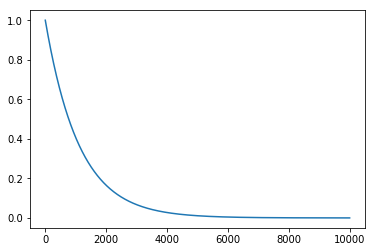

In [18]:
plt.plot(time, epsilon)
plt.show()

In [19]:
time = np.arange(0,1000)
epsilon = []
for i in range(0,1000):
    epsilon.append(0 + (1 - 0.0001) * np.exp(-0.003*i))
    z = np.random.random()

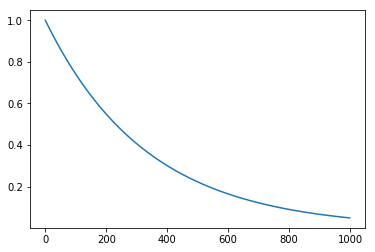

In [20]:
plt.plot(time, epsilon)
plt.show()